In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib as mpl

#%matplotlib notebook
#import cmcrameri.cm as cmc  #scientific color maps - perceptually uniform see https://www.fabiocrameri.ch/colourmaps-userguide/
from scipy import signal
from scipy.optimize import fsolve
import plotly.express as px
from scipy.stats import norm
from sklearn.preprocessing import normalize
import cmcrameri.cm as cmc  #scientific color maps - perceptually uniform
from lmfit import minimize, Parameters, create_params, model
from scipy.signal import sawtooth


This tutorial shows the connection between differential optical absorbance and the thermodynamics of electrochemical sufrace redox processes. We begin by enerating three Frumkin isotherms. These functions are much like the nernst equation, but describe the equilibrium generation of a new electrochemical species from a redox process. 

$E=E^0+ ln(\frac{\theta}{1-\theta})+r\theta$

where $\theta$ is the coverage of the species being generated by a redox process, $E^0$ is the standard potential of the  and r is term describing the perturbation in potential that arises from any additional interactions the species might have compared to what is generated. Below we generate three such isotherms. These decribe the generation of three species from three processes. 

In [27]:
#This block generates three frumkin isotherms, note r here is actually a place holder for r/F
# if you want the true r in eV then multiply by F to get units of joules then convert to eV - you will get the same number but in eV not V (lol)
E0=0.4
r=0.1

E01=0.7
r1=0.15

E02=0.9
r2=0.27

t=np.arange(0,240,0.01)
def sawtooth2(time, amplitude, period, phase):
    """ This function generates a sawtooth wave with the following parameters:
    Once, fitted is used to generate an interpolation function from t-->V.
    time: time array
    amplitude: amplitude of the wave
    period: period of the wave
    phase: phase of the wave
    """
    return amplitude * sawtooth((2*np.pi  * time)/(period)-phase, 0.5)


E=sawtooth2(t, 1, 80, 0)
 # here is the E aray we use to calculate the theta values from the frumkin equation
# for nice plots later keep the upper limit of E about 0.5 V more than E02 (note this will depend on the r value that you choose)


# define three identical frumkin functions to numerically solve for the two theta arrays 
# these are arranged in an exponential form solving for theta on one hand with some dependence on theta on the other
#because fsolve does not like logarithms 


def jig(t, E, E0, r):
    return np.exp((E-E0-r*t)/0.0256)/(1+np.exp((E-E0-r*t)/0.0256))-t

def jig_alt(t, E, E01, r1):
    return np.exp((E-E01-r1*t)/0.0256)/(1+np.exp((E-E01-r1*t)/0.0256))-t

def jig_alt2(t, E, E02, r2):
    return np.exp((E-E02-r2*t)/0.0256)/(1+np.exp((E-E02-r2*t)/0.0256))-t

#initialise a bunch of empty arrays to store the theta values and one array of ones which will be used later

theta0=np.ones(len(E))
theta=np.zeros(len(E))
theta1=np.zeros(len(E))
theta2=np.zeros(len(E))

# this for loop numericaly solves and populates the theta arrays

for n in range(len(E)):
    def jig2(t):
        return jig(t,E[n],E0,r)
    def jig2_alt(t):
        return jig_alt(t,E[n],E01,r1)
    def jig2_alt2(t):
        return jig_alt2(t,E[n],E02,r2)
    theta[n]=fsolve(jig2, 0.5)
    theta1[n]=fsolve(jig2_alt, 0.5)
    theta2[n]=fsolve(jig2_alt2, 0.5)



/var/folders/vm/d986p9hx0rlglk34b43v_h180000gn/T/ipykernel_7961/3416548235.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta[n]=fsolve(jig2, 0.5)
/var/folders/vm/d986p9hx0rlglk34b43v_h180000gn/T/ipykernel_7961/3416548235.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta1[n]=fsolve(jig2_alt, 0.5)
/var/folders/vm/d986p9hx0rlglk34b43v_h180000gn/T/ipykernel_7961/3416548235.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta2[n]=fsolve(jig2_alt2

In [28]:
[1, 2,]

[1, 2]

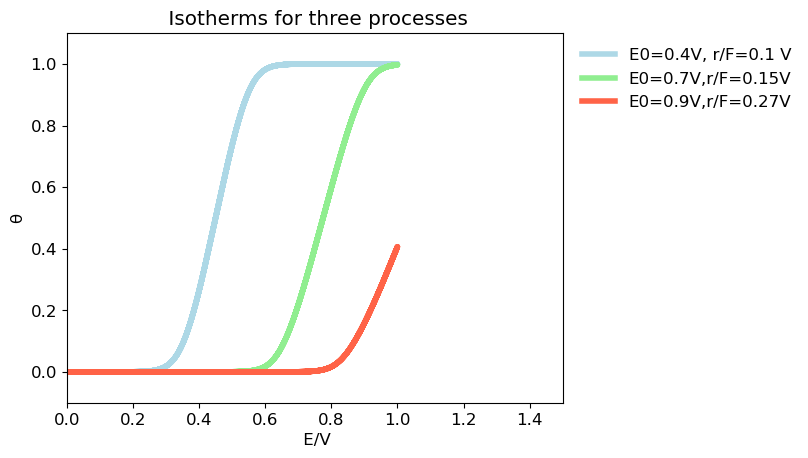

In [29]:
# this block checks the output - uncomment if you want to check
#def iso(t, E0, r):
  #  return E0+0.0256*np.log((t)/(1-t))+r*t
#def iso2(t):
 #   return iso(t,E0,r)

#t=np.arange(1e-5,0.99999,1e-6)
#E2=iso2(t)



plt.plot(E, theta, 'lightblue', linewidth=4, label = f'E0={E0}V, r/F={r} V') 
plt.plot(E, theta1, 'lightgreen', linewidth=4, label = f'E0={E01}V,r/F={r1}V') 
plt.plot(E, theta2, 'tomato',  linewidth=4, label = f'E0={E02}V,r/F={r2}V') 

plt.xlabel(' E/V')
plt.ylabel('\u03B8')
plt.title(' Isotherms for three processes')
plt.xlim(0,1.5)
plt.ylim(-0.1,1.1)
plt.legend(frameon=False)
plt.rcParams.update({'font.size':12})
plt.legend(frameon=False,loc='upper center', 
    bbox_to_anchor=(1.25, 1),
    ncol=1, )


Consider the equation for differential absorption for a process:

$nA \rightarrow (n-m)A + mB$

$\Delta A = \Delta \epsilon C_m$ 


where $C_m$ is the concentration corresponding to m moles being converted and Δ$\epsilon$ is the difference in molar attentuation coeffcients of the two species (A and B)

The units of $ \Delta \epsilon$ are $mol^{-1} dm^3$  and the units of $C_m$ are $mol dm^{-3}$
one may change the units of both simultainiously without changeing any other quality given the two terms are reciprocal
1. cancel all volume units given we consider the same volume
2. re-write 1 mol as 96485 C based on the assumtion of a single electron couple
the new equaiton will read


$\Delta A = Δα_q$ Q

where $Δα_q$ is the coulometric differential attenuation coeffcient in units of $C^{-1}$ and Q is the charge passed in the process 

(note for simplicity here I am not considering current density of charge density but these extra area units can easily be introduced)

Given the surface has a total number of available sites that can be oxidised we can re-write :

$Q = Q_{max} \theta_{gen}$ where theta is the generation function given by the frumkin isotherm. Equally converting Q to number we could say $\frac{Q_{max}} {e*\theta_{gen}} = N_{max} \theta_{gen}$  where e is the elementary charge. 

Thus ΔA=ΔαCm=Δα$_q$ Q=Δα$_𝑞$Q$_{max}$ θ$_{gen}$ = Δα$_q$ e Nmax θ\$_{gen}$ 

**we therefore see that differential spectra monitor the the normalised extent of a given prcoess completion AND NOT THE ABSOLUTE COVERAGE OF A GIVEN SPECIES

In the following I will:
1. decide on an arbitary Nmax (i.e. Q max)
2. generate three arbitary spectra corresponding to three values of Δα_q
3. generate a differential absorption spectrum by scaling these by the three θgen values above
4. show how these spectra can be deconvoluted into meaningful components
5. fit the results and re-obtain all the quantities we started with




Text(0.5, 1.0, 'Three  spectra generated from the sum of two gaussians')

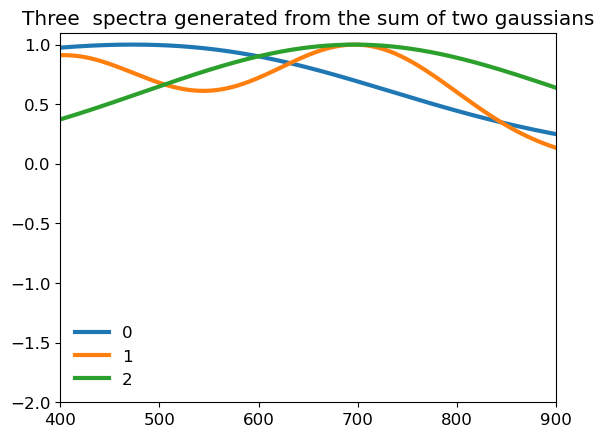

In [30]:
muWL_L=(400,400,650)
muWL1_L=(600,700,800)
sigma_L=(300,100,200)
sigma1_L=(150,100,200)
S1=(1,1,1)
S2=(0.1,1.1,0.5)
WL_arr=np.arange(400,900,1)

def Gau(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)
#Pdf1 = S1*Gau(WL_arr, muWL, sigma)
#Pdf2 = S2*Gau(WL_arr, muWL1, sigma1)

def Multi_Gau(WL,muWL,sigma,muWL1,sigma1,S,S1):
    # Generate data points for x-axis

    # Compute the probability density function (PDF) for the normal distribution
    pdf1 = Gau(WL, muWL, sigma)
    pdf2 = Gau(WL, muWL1, sigma1)
    Tot = S*pdf1+S1*pdf2
    return Tot/np.max(Tot)
Out=np.zeros([len(WL_arr),len(muWL_L)])
for i in range(len(muWL_L)):
    Out[:,i]=Multi_Gau(WL_arr,muWL_L[i],sigma_L[i],muWL1_L[i],sigma1_L[i],S1[i],S2[i])
    plt.plot(WL_arr, Out[:,i], label = f'{i}',linewidth=3) 
plt.legend(frameon=False)
plt.xlim(400,900)
plt.ylim(-2,1.1)
plt.title('Three  spectra generated from the sum of two gaussians')

#test = Multi_Gau(WL_arr,muWL,sigma,muWL1,sigma1,S1,S2)
#plt.plot(WL_arr, test,'b', label = 'Delta T3') 
#plt.plot(WL_arr, Pdf1,'r', label = 'Delta T3') 
#plt.plot(WL_arr, Pdf2,'g', label = 'Delta T3') 


Here I decide three arbitary coulombetric attenuation coeffcients 
these always seem to be on the order of 1/alpha = 0.05 C/O.D so I am going to choose numbers around 20 O.D/C
I am choosing the extinction coefficients to be progressivley larger this does not have to be the case - as
long as $\Delta \alpha$ is positive the signal will go up in in the case of the 0>1>2>3 type conversion MK model
This is because $\Delta \alpha$ is the coulometric absorbtivity for the step in question and is not relative to grond
except in the case of step 0>1 in example of this MK model

We also need a maximum charge/number of states. These don't have to be the same number but let's assume there is a 1:1:1 stoichiomety between all interconverting states as might be expected in the 0>1>2>3 type conversion

From my work, the largest Q max I have measured is about 0.0025 C let's use this number 

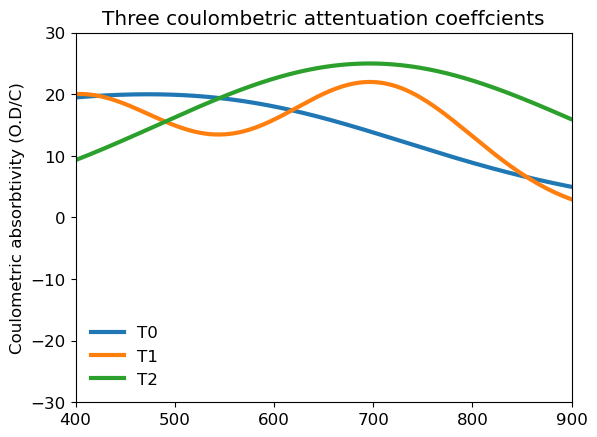

In [31]:
alpha_prime=(20,22,25) #array of attenuation coeffcients

spectra=np.zeros([len(WL_arr),len(muWL_L)])
for i in range(len(muWL_L)):
    spectra[:,i]=Out[:,i]*alpha_prime[i]
    plt.plot(WL_arr, spectra[:,i], label = f'T{i}',linewidth=3) 
plt.legend(frameon=False)
plt.xlim(400,900)
plt.ylim(-30,30)
plt.title('Three coulombetric attentuation coeffcients')
plt.ylabel('Coulometric absorbtivity (O.D/C)') # note the unit of delta theta here

Qmax=0.0025

Let's now put it all together and generate spectra  using  ΔA=Δα$_q$ Q$_{max}$ θ$_{gen}$ for each species


In [32]:
spectra.shape 

(500, 3)

In [33]:
E.shape[0]

24000

24000


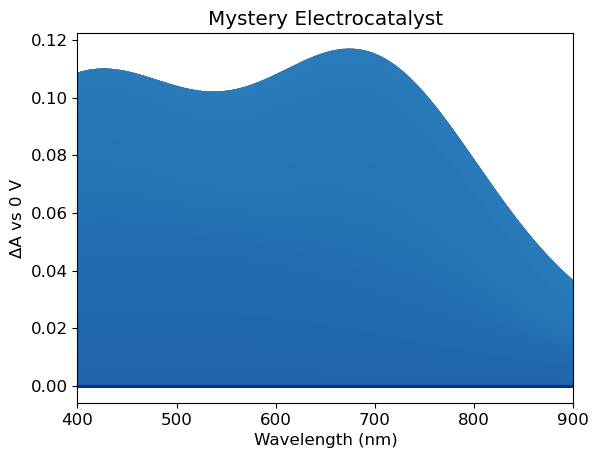

In [34]:
DOD1=np.zeros([len(WL_arr),len(E)])
DOD2=np.zeros([len(WL_arr),len(E)])
DOD3=np.zeros([len(WL_arr),len(E)])

for i in range(len(E)):
    DOD1[:,i]=spectra[:,0]*Qmax*theta[i]
    DOD2[:,i]=spectra[:,1]*Qmax*theta1[i]
    DOD3[:,i]=spectra[:,2]*Qmax*theta2[i]
    
SEC=DOD1+DOD2+DOD3
n=SEC.shape[1]
cmap = cmc.roma

colors=cmap(np.linspace(0,1,n))

print(n)
for i in range(len(E)):
    plt.plot(WL_arr, SEC[:,i],color=colors[i],linewidth=2) 
plt.title('Mystery Electrocatalyst')
plt.ylabel('ΔA vs 0 V') 
plt.xlabel('Wavelength (nm)') 
plt.xlim(400,900)
cmap = cmc.roma
norm = mpl.colors.Normalize(vmin=0.2, vmax=1.4)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
#plt.colorbar(sm, ticks=None, label='$U (V) $')

In [35]:
type(WL_arr)
type(SEC)
final=np.zeros([len(WL_arr),len(E)])
#final[:,0]=WL_arr
final=SEC

final=pd.DataFrame(final)
Efin=np.zeros(len(E))
Efin=E
final.columns=Efin
final.index=WL_arr

final.to_csv('synth.csv')
#np.concatenate(WL_arr,SEC, axis=1)
#final.shape
#Final=pd.DataFrame(final).T
#Final.head()


How do we analyse this complex spectral evolution? The spectra have very specific properties in the special reagion where only one component is present
$\Delta A = Q_{max}\Delta \alpha(\lambda)\theta(E)$


If we subtract two $\Delta A$ values:


$\Delta \Delta(A) = Q_{max}\Delta \alpha_{max}(\lambda_{max})[\theta(E+\Delta E)-\theta(E)]=Q_{max}\Delta \alpha(\lambda)\Delta \theta $

At the wavelength where the coulombetric attentuation coeffcient is maximsed $\Delta \Delta(A) is maximised

[$\Delta \Delta(A)]_{max}=Q_{max}\Delta \alpha(\lambda_{max})\Delta \theta $

The normalised $\Delta \Delta(A)$ spectrum is a constant in a potential region where  only one component is changing

$ \overline{\Delta\Delta(A)} =\frac{\Delta \Delta(A)}{[\Delta \Delta(A)]_{max}}=\frac{Q_{max}\Delta \alpha(\lambda)\Delta \theta}{Q_{max}\Delta \alpha(\lambda_{max})\Delta \theta}=\frac{\alpha(\lambda)}{\alpha(\lambda_{max}}$

Evaluated at two E values we get the same result as the $\Delta \theta$ will cancel:

$\overline{\Delta\Delta(A)}_{E2}-\overline{\Delta\Delta(A)}_{E1}=0$

Let's calculate $\overline{\Delta\Delta(A)}$

In [36]:
# intialise the dataframes that will hold the unnormalised difference of delta and and the normalised difference

Diff=pd.DataFrame(np.zeros([final.index.size,final.columns.size]), index=final.index) 
DiffN=pd.DataFrame(np.zeros([final.index.size,final.columns.size]), index=final.index) #normalised
E_diff=np.zeros(final.columns.size)


for n in range(final.columns.size):
    if n!= final.columns.size-1:
        Diff.iloc[:,n]=final.iloc[:,n+1]-final.iloc[:,n]  # subtract previous potential note, this will not work for expeirmental data as the values will be too close
        DiffN.iloc[:,n]=Diff.iloc[:,n]/Diff.iloc[:,n].max()
        E_diff[n]=E[n]
    else:
        print(n)
        Diff.iloc[:,n]=None 
        DiffN.iloc[:,n]=None
        E_diff[n]=None



23999


/var/folders/vm/d986p9hx0rlglk34b43v_h180000gn/T/ipykernel_7961/698182297.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'None' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  Diff.iloc[:,n]=None
/var/folders/vm/d986p9hx0rlglk34b43v_h180000gn/T/ipykernel_7961/698182297.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'None' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  DiffN.iloc[:,n]=None


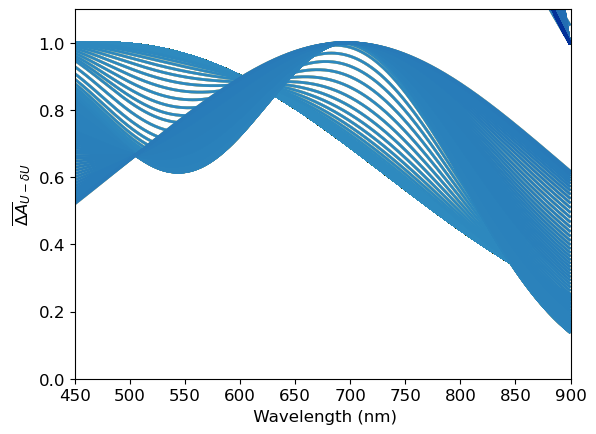

In [37]:
#plotting the values  - note this block cannot be run without first executing the above block. If you want to run it run the above first
step=10
n=(DiffN.columns.size//step)+1
cmap = cmc.roma
colors=cmap(np.linspace(0,1,n))

i=0
for ind in range(0,DiffN.columns.size,step):   
    plt.plot(DiffN.index.to_numpy(), DiffN[ind].to_numpy(), color=colors[i], linewidth=2)
    i=i+1

plt.xlabel(' Wavelength (nm)')
plt.ylabel('$ \overline{\Delta A}_{U-\delta U}$')
plt.xlim(450,900)
plt.ylim(0,1.1)
cmap = cmc.roma
norm = mpl.colors.Normalize(vmin=0.2, vmax=1.4)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
#plt.colorbar(sm, ticks=None, label='$U (V) $')
plt.rcParams['figure.dpi'] = 300

#write to CSV
DiffN.columns=E_diff
DiffN.to_csv('DiffNsynth.csv')



From the above, we see how  $\overline{\Delta\Delta(A)}$ converges to a constant in three distinct regions (green, teal and blue). If we calculate two values of $\overline{\Delta\Delta(A)}_{E2}-\overline{\Delta\Delta(A)}_{E1}$, averaging over all wavelenghts and taking the modulus of the differnece to make the result more plotable we see how the function tends to zero in regions where only one component exists. At these potentials we can confidently take spectra to be 'pure' and use them in a linear combination fitter to reconstruct $\theta_{gen}$ for each species!


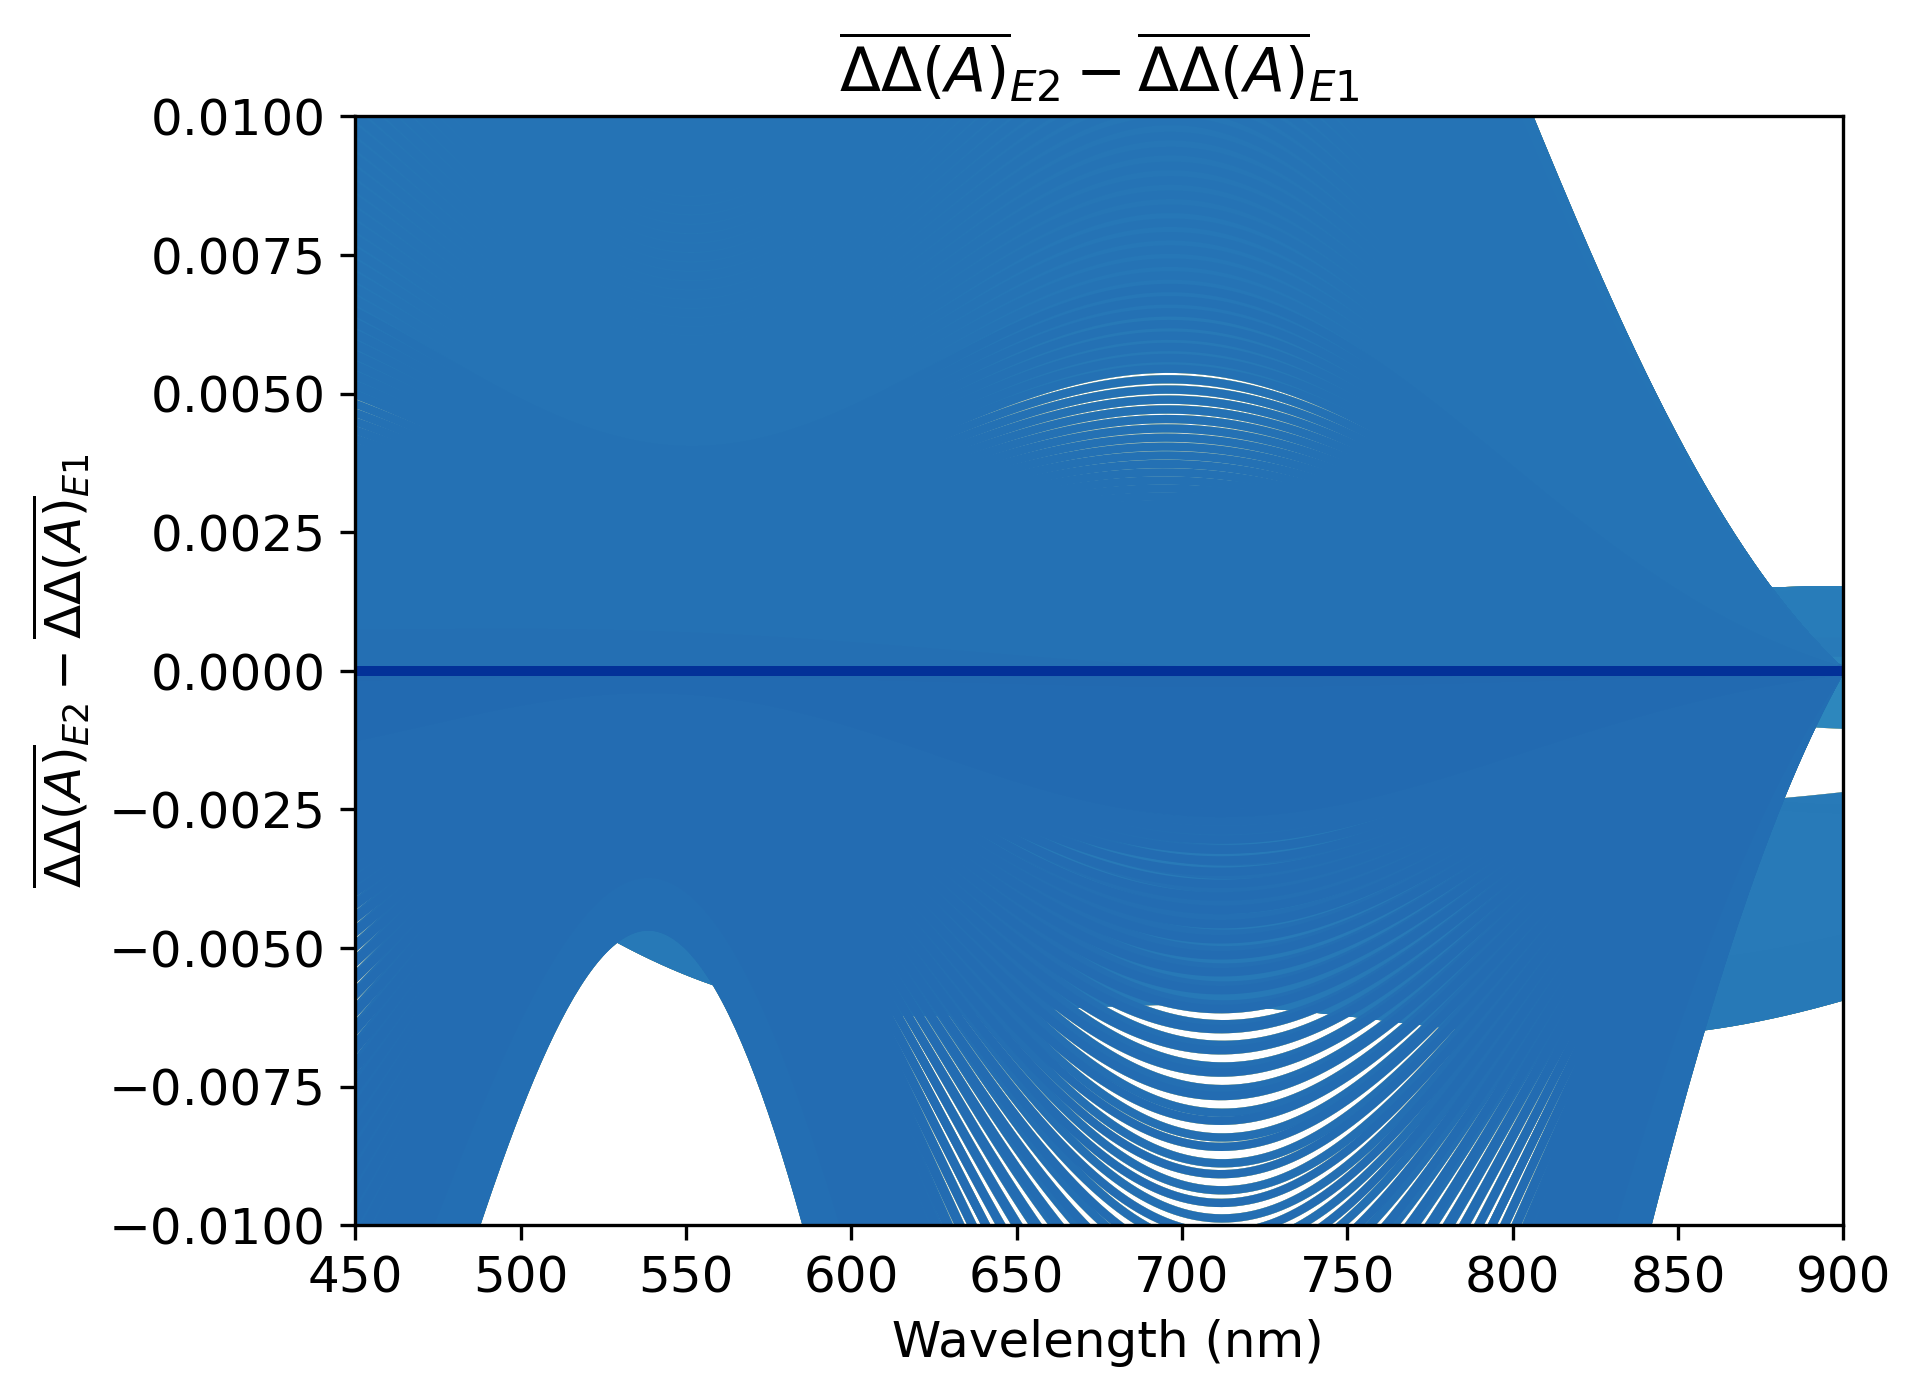

In [38]:
DiffN.columns=E_diff

DDif=pd.DataFrame(np.zeros([DiffN.index.size,DiffN.columns.size//2]), index=final.index)
dDif=pd.DataFrame(np.zeros([DiffN.index.size,DiffN.columns.size//2]), index=final.index)

EDDif=np.zeros(len(E_diff)//2)


j=0
for n in range(DiffN.columns.size):
    if n%2 ==0 and n>=2:
        dDif.iloc[:,j]=(DiffN.iloc[:,n]-DiffN.iloc[:,n-1])
        DDif.iloc[:,j]=abs(dDif.iloc[:,j])  # take the magnitude as we want to find the zero region and we want to sum later
        EDDif[j]=E_diff[n]
        j=j+1

        
n=DDif.columns.size
cmap = cmc.roma
colors=cmap(np.linspace(0,1,DDif.columns.size))
     
for ind in DDif.columns:
    plt.plot(DiffN.index.to_numpy(), dDif[ind].to_numpy(), color=colors[ind],linewidth=2)
plt.xlabel(' Wavelength (nm)')
plt.ylabel('$\overline{\Delta\Delta(A)}_{E2}-\overline{\Delta\Delta(A)}_{E1}$')
plt.title('$\overline{\Delta\Delta(A)}_{E2}-\overline{\Delta\Delta(A)}_{E1}$')
plt.xlim(450,900)
plt.ylim(-0.01,0.01)
cmap = cmc.roma
norm = mpl.colors.Normalize(vmin=0.2, vmax=1.4)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
#plt.colorbar(sm, ticks=None, label='$U (V) $')
plt.rcParams['figure.dpi'] = 75

#plt.plot(DiffN.index.to_numpy(), DDif[1].to_numpy(), color=colors[1])    
dDif.columns=EDDif   
dDif.to_csv('testfile.csv')

(0.4, 1.1)

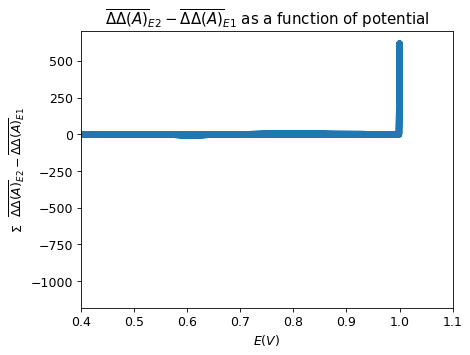

In [39]:
EDDif[-1]=None
SUM_DDIF=dDif.sum()
plt.plot(EDDif, SUM_DDIF,linewidth=6) 
plt.title('$\overline{\Delta\Delta(A)}_{E2}-\overline{\Delta\Delta(A)}_{E1}$ as a function of potential')
plt.ylabel('$ \Sigma \ \ \overline{\Delta\Delta(A)}_{E2}-\overline{\Delta\Delta(A)}_{E1}$')
plt.xlabel('$E (V)$')
plt.xlim(0.4,)



The form of the above is interesting - the negative  points arise from the sigmoidal behavoir of $\theta_{Ti}$ - no transitions ever fully ends - it's growth rate just exponentially decays with potential upon completion. As the next transition starts it's growth rate is exponentially growing - thus long before E0 of T2 there will be a point where the absorption at some E is larger than at E+$\delta$. This is blown up by the normalisation of the two spectra. Regardless, components are around 0.45 0.7 and 1.05 so let's grab these as our components

In [40]:
#comps=np.array([DDif.index, DDif[0.44]])
Comps = pd.DataFrame([DiffN[0.45], DiffN[0.71], DiffN[1.05]]).T
Comps.index=DDif.index

i=0
for ind in Comps.columns:
    plt.plot(Comps.index.to_numpy(), Comps[ind].to_numpy(),  linewidth=2, label = f'$\Delta  α${i+1}')
    plt.plot(WL_arr, Out[:,i], 'k',   linewidth=1, linestyle = '--', label = f' $\Delta A${i+1} Component') 
    i=i+1
plt.xlim(400,900)
plt.ylim(0,1.1)
plt.title('Comparing $\overline{\Delta α}$ and $ \overline{\Delta A}_{U-\delta U}$')    
plt.ylabel('Normalised $\Delta A$') 
plt.xlabel('Wavelength (nm)')
plt.legend(frameon=False,loc='upper center', 
    bbox_to_anchor=(1.25, 1),
    ncol=1, )

KeyError: 0.45

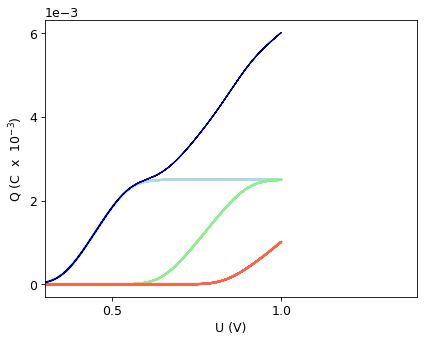

In [41]:
#quick calculation of Q total - we want to do this so we can compare against the results 

Q1=Qmax*theta
Q2=Qmax*theta1
Q3=Qmax*theta2
Q_T=Q1+Q2+Q3
plt.plot(E,Q1, 'lightblue', label = 'Redox process 1', linewidth=2)
plt.plot(E,Q2, 'lightgreen', label = 'Redox process 2', linewidth=2)
plt.plot(E,Q3,'tomato',label = 'Redox process 3', linewidth=2)

plt.plot(E,Q_T, 'darkblue', linewidth=1)
plt.ylabel('Q (C  x  $ 10 ^{-3}$)') 
plt.xlabel('U (V)')
plt.xlim(0.3,1.4)

plt.rcParams.update({'font.size':25})
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))





Quick calculation of the current

array([ 8.75875070e-29,  8.84512614e-29,  9.01958062e-29, ...,
       -9.19747590e-29, -9.01958062e-29, -8.93150157e-29])

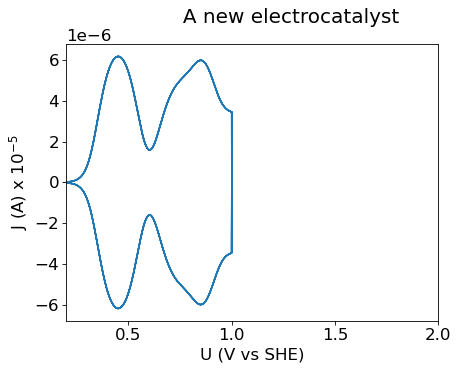

In [43]:
J=np.gradient(Q_T) #- we want to do this so we can compare against the results of fitting
J1=np.gradient(Q1)
J2=np.gradient(Q2)
J3=np.gradient(Q3)

plt.plot(E,J)
#plt.plot(E,J1)
#plt.plot(E,J2)
#plt.plot(E,J3)
plt.title('             A new electrocatalyst ')

plt.ylabel('J (A) x $10^{-5}$') 
plt.xlabel('U (V vs SHE)')
plt.xlim(0.2,2)

plt.rcParams.update({'font.size':16})
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


J

In [ ]:
x = theta # shallow copy just to use in the fit
noise = np.random.normal(size=x.size, scale=0.0001) # if you want noise in the fit turn this up

#plt.plot(WL_arr,data)
# generate experimental uncertainties
uncertainty = abs(0.16 + np.random.normal(size=WL_arr.size, scale=0.0005))

variables = [0.01,0.01, 0.01]

params = Parameters()
params.add('beta0', value=0.001)
params.add('beta1', value=0.007)
params.add('beta2', value=0.002)


Comp2=np.array(Comps)


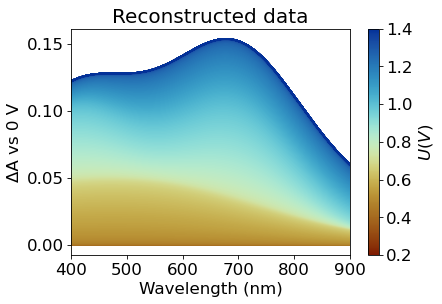

In [ ]:
from lmfit import minimize, Parameters


def residual(params, Comp2, data, uncertainty):
    beta0 = params['beta0']
    beta1 = params['beta1']
    beta2 = params['beta2']

    model = beta0*Comp2[:,0]+beta1*Comp2[:,1]+beta2*Comp2[:,2]
    return (data-model) / uncertainty

params = Parameters()
params.add('beta0', value=0.001)
params.add('beta1', value=0.007)
params.add('beta2', value=0.002)

#initalise the array that will hold the fitted values as the reconstructed spectra
beta_array=beta_array=np.zeros([3,SEC.shape[1]])
SEC_reconstructed=np.zeros(SEC.shape)
Residuals=np.zeros(SEC.shape)
#color map stuff

cmap = cmc.roma
colors=cmap(np.linspace(0,1,SEC.shape[1]))

for i in range(SEC.shape[1]):
    data=SEC[:,i]
    out = minimize(residual, params, args=(Comp2, data, uncertainty))
    SEC_reconstructed[:,i]=Comp2[:,0]*out.params['beta0'].value + Comp2[:,1]*out.params['beta1'].value+ Comp2[:,2]*out.params['beta2'].value
    Residuals[:,i]=SEC[:,i]-SEC_reconstructed[:,i]
    beta_array[:,i]=np.array([out.params['beta0'].value,out.params['beta1'].value,out.params['beta2'].value]).T
    plt.plot(WL_arr,SEC_reconstructed[:,i],color=colors[i])

    
    
plt.title('Reconstructed data')
plt.ylabel('ΔA vs 0 V') 
plt.xlabel('Wavelength (nm)') 
plt.xlim(400,900)    
cmap = cmc.roma
norm = mpl.colors.Normalize(vmin=0.2, vmax=1.4)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
#plt.colorbar(sm, ticks=None, label='$U (V) $')    

#plt.rcParams['figure.dpi'] = 75


(0.0, 1e-13)

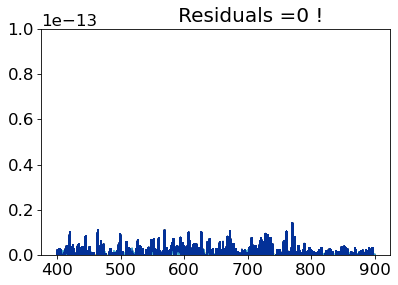

In [ ]:
# now we can check how the residuals look
for i in range(SEC.shape[1]):
   plt.plot(WL_arr,Residuals[:,i],color=colors[i])
plt.title('           Residuals =0 !')
plt.ylim(0,1e-13)

#they look good !

Text(0.5, 0, 'U (V vs SHE)')

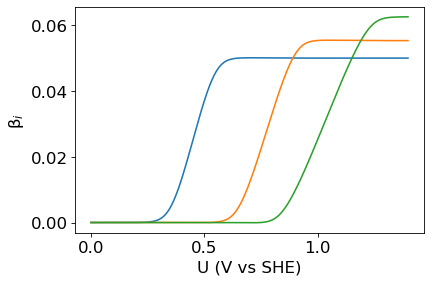

In [ ]:
#now let's understand how beta varies with E

plt.plot(E,beta_array[0,:])
plt.plot(E,beta_array[1,:])
plt.plot(E,beta_array[2,:])
plt.ylabel('β$_i$') 
plt.xlabel('U (V vs SHE)') 


$\Delta A = Q_{max}\Delta \alpha(\lambda)\theta(E)$

but as $ \overline{\Delta\alpha}=\frac{\alpha(\lambda)}{\alpha(\lambda_{max})}$

$\Delta A = Q_{max}\overline{\Delta\alpha} \ \Delta \alpha(\lambda_{max})\theta(E)$

For multiple components therefore

$\Delta A(E) = \sum_i Q_{max, i}\overline{\Delta\alpha_i} \ \Delta \alpha_i(\lambda_{max})\theta_i(E)$

We do a linear combination fitting with $\overline{\Delta\alpha_i}$ - if we bunch all other terms as $\beta$:


$\Delta A(E) = \sum_i \beta_i(E) \overline{\Delta\alpha_i} $

where 

$\beta_i = Q_{max, i}\ \Delta \alpha_i(\lambda_{max})\theta_i(E)$

To prove this approach we wish to recover the frumkin isotherms we started with i.e. $\theta_i$

$\frac{\beta_i}{Q_{max, i}\ \Delta \alpha_i(\lambda_{max})} = \theta_i(E)$

Also worth pointing out that:

$\frac{\beta_i}{\Delta \alpha_i(\lambda_{max})} = \theta_i(E) Q_{max, i}=Q_i$

This is the partial charge. Let's convert it to current and compare to what we should have. Then, let's recover the frumkin isotherms as a final proof of this approach.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


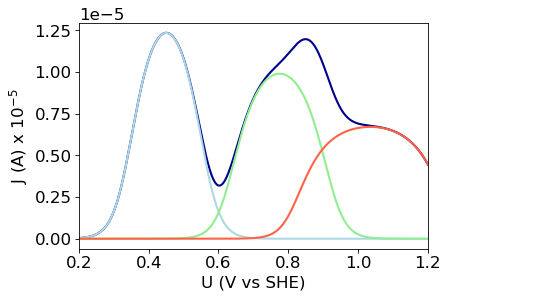

In [ ]:
alpha_prime1=np.array(alpha_prime)
Q_i_recon=np.zeros(beta_array.shape)
J_i_recon=np.zeros(beta_array.shape)

for i in range(beta_array.shape[0]):
    Q_i_recon[i,:]=beta_array[i,:]/alpha_prime1[i]
    J_i_recon[i,:]=np.gradient(Q_i_recon[i,:])

plt.plot(E,J, 'darkblue', linewidth=2)
plt.plot(E,J1,'lightblue', linewidth=2)
plt.plot(E,J2, 'lightgreen', linewidth=2)
plt.plot(E,J3,  'tomato', linewidth=2)


#plt.plot(E,J_i_recon[0,:],linestyle = '--',label = 'Redox process 1')
#plt.plot(E,J_i_recon[1,:],linestyle = '--',label = 'Redox process 2')
#plt.plot(E,J_i_recon[2,:],linestyle = '--',label = 'Redox process 3')



plt.ylabel('J (A) x $10^{-5}$') 
plt.xlabel('U (V vs SHE)')
plt.xlim(0.2,1.2)
#plt.title('             A new electrocatalyst ')

plt.rcParams.update({'font.size':16})
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(frameon=False)
plt.legend(frameon=False,loc='upper center', 
    bbox_to_anchor=(1.3, 1),
    ncol=1, )
    
    

Text(0.5, 1.0, '          reconstructing Q')

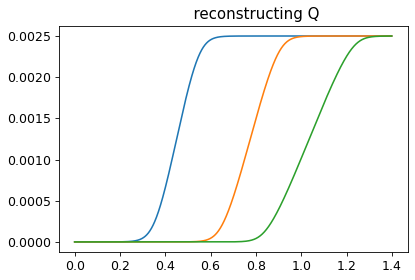

In [ ]:
plt.plot(E,Q1)
plt.plot(E,Q2)
plt.plot(E,Q3)

#plt.plot(E,Q_i_recon[0,:],linestyle = '--')
#plt.plot(E,Q_i_recon[1,:],linestyle = '--')
#plt.plot(E,Q_i_recon[2,:],linestyle = '--')
plt.title('          reconstructing Q')


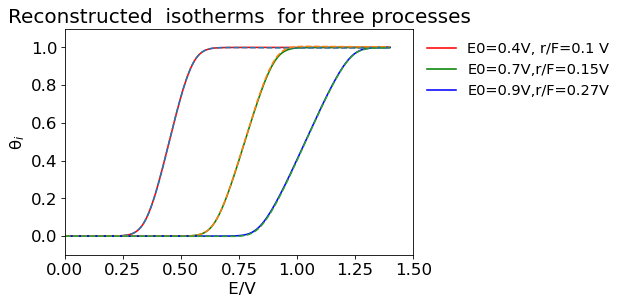

In [ ]:
Theta_i_recon=np.zeros(beta_array.shape)

for i in range(beta_array.shape[0]):
    Theta_i_recon[i,:]=beta_array[i,:]/(alpha_prime1[i]*Qmax)

plt.plot(E, theta, 'r', label = f'E0={E0}V, r/F={r} V') 
plt.plot(E, theta1, 'g', label = f'E0={E01}V,r/F={r1}V') 
plt.plot(E, theta2, 'b', label = f'E0={E02}V,r/F={r2}V') 


plt.plot(E,Theta_i_recon[0,:],linestyle = '--')
plt.plot(E,Theta_i_recon[1,:],linestyle = '--')
plt.plot(E,Theta_i_recon[2,:],linestyle = '--')

plt.xlabel(' E/V')
plt.ylabel('\u03B8$_i$')
plt.title('Reconstructed  isotherms  for three processes')
plt.xlim(0,1.5)
plt.ylim(-0.1,1.1)
plt.legend(frameon=False)
plt.rcParams.update({'font.size':14})
plt.legend(frameon=False,loc='upper center', 
    bbox_to_anchor=(1.3, 1),
    ncol=1, )
    
    
